# TF Tau Finder w/Freqs

In [1]:
# fullwidth notebook cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# suppress tensorflow FutureWarning
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import h5py
import tensorflow as tf

# for reading & slicing data
import pandas as pd

# for data preprocessing
from sklearn.preprocessing import MinMaxScaler

import numpy as np

***

## Load data

In [15]:
data_path = 'wrap_data_test_2.csv'
data_df = pd.read_csv(data_path, dtype = float)

In [16]:
data_df.head()

,tau,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,4.263624,2.678914,2.681533,2.684151,2.686770,2.689389,2.692007,2.694626,2.697245,2.699863,...,0.19912,0.199218,0.199316,0.199413,0.199511,0.199609,0.199707,0.199804,0.199902,0.2
1,30.689476,0.433210,0.452059,0.470909,0.489758,0.508607,0.527456,0.546306,0.565155,0.584004,...,0.19912,0.199218,0.199316,0.199413,0.199511,0.199609,0.199707,0.199804,0.199902,0.2
2,77.284880,-1.705960,-1.658493,-1.611025,-1.563557,-1.516089,-1.468621,-1.421154,-1.373686,-1.326218,...,0.19912,0.199218,0.199316,0.199413,0.199511,0.199609,0.199707,0.199804,0.199902,0.2
3,-21.807557,-1.135722,-1.149116,-1.162510,-1.175904,-1.189298,-1.202692,-1.216086,-1.229480,-1.242874,...,0.19912,0.199218,0.199316,0.199413,0.199511,0.199609,0.199707,0.199804,0.199902,0.2
4,39.138534,-0.541275,-0.517237,-0.493198,-0.469159,-0.445121,-0.421082,-0.397044,-0.373005,-0.348967,...,0.19912,0.199218,0.199316,0.199413,0.199511,0.199609,0.199707,0.199804,0.199902,0.2


### Seperate data into training and testing

In [17]:
# Randomly sample 80%
training_data_df = data_df.sample(frac = 0.8)

In [19]:
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

### Split the data into X and Y

In [20]:
# drop the tau column from the X data (data to train with)
# axis = 1 drops the column
X_training = training_data_df.drop('tau', axis = 1).values

# retain only the tau column (value to predict) for the Y data
Y_training = training_data_df[['tau']].values

In [21]:
# drop the tau column from the X data (data to train with)
# axis = 1 drops the column
X_testing = testing_data_df.drop('tau', axis = 1).values

# retain only the tau column (value to predict) for the Y data
Y_testing = testing_data_df[['tau']].values

In [22]:
# Create scalars for inputs and outputs
X_scaler = MinMaxScaler(feature_range = (0,1))
Y_scaler = MinMaxScaler(feature_range = (0,1))

In [23]:
# Scale training input and output
X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

In [24]:
# Scale testing data using same scaler
X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

In [25]:
X_scaled_training.shape

(8000, 2048)

In [26]:
msg = 'Note: Y values were scaled by multiplying by {:.10f} and adding {:.4f}'
print(msg.format(Y_scaler.scale_[0], Y_scaler.min_[0]))

Note: Y values were scaled by multiplying by 0.0050009846 and adding 0.4999


In [27]:
# Define how many inputs and outputs are in our neural network
number_of_inputs = X_scaled_training.shape[1]
number_of_outputs = Y_scaled_training.shape[1]

In [28]:
# define how many neurons we want in each layer of our NN
layer_1_nodes = 20
layer_2_nodes = 500
layer_3_nodes = 50

In [29]:
# Define model parameters
learning_rate = 0.001
training_epochs = 100
display_step = 2

In [30]:
# Input Layer
with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))
    
# Layer 1
with tf.variable_scope('layer_1'):
    
    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())
    
    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)
    
# Layer 2
with tf.variable_scope('layer_2'):
    
    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())
    
    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)
    
# Layer 3
with tf.variable_scope('layer_3'):
    
    biases = tf.get_variable(name = "biases3",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())
    
    weights = tf.get_variable(name = "weights3",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)
    
# Output layer

with tf.variable_scope('output'):
    
    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())
    
    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_3_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)
    
with tf.variable_scope('cost'):
    
    Y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))

    
with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-05).minimize(cost)
    
with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()
    
saver = tf.train.Saver()

In [31]:
# initialize a session to run TF operations
with tf.Session() as session:
    
    # Run the global variable initilizer to init all variables and layers
    session.run(tf.global_variables_initializer())
    
    # Create log writers to record training progress
    # Store training and testing data separately
    training_writer = tf.summary.FileWriter('logs4/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs4/testing', session.graph)
    
    
    # Run the optimizer over and over to train the network
    # One epoch is one full run through the training data set
    for epoch in range(training_epochs):
        
        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training})

        # Every display_step steps, log our process
        if epoch % display_step == 0:
            
            training_feed = {X: X_scaled_training, Y: Y_scaled_training}
            training_cost, training_summary = session.run([cost, summary],
                                                    feed_dict = training_feed)
            
            testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing}
            testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
            
            print(epoch, training_cost, testing_cost)
            
            # write the current status to the log files
            training_writer.add_summary(training_summary, epoch)
            testing_writer.add_summary(testing_summary, epoch)
            
    print('Training done')
    
    final_training_cost = session.run(cost,
                                      feed_dict = {X: X_scaled_training,
                                                   Y: Y_scaled_training})
    
    final_testing_cost = session.run(cost,
                                     feed_dict = {X: X_scaled_testing,
                                                  Y: Y_scaled_testing})

    print('Final Training Cost: {}'.format(final_training_cost))
    print('Final Testing Cost: {}'.format(final_testing_cost))
    
    
    # Now that the NN is trained, lets use it to make predictions.
    # pass in the X testing data and run the prediction operation
    Y_prediction_scaled = session.run(prediction,
                                      feed_dict = {X:X_scaled_testing})

    # Unscale the data back to its original units (dollar$)
    Y_predicted = Y_scaler.inverse_transform(Y_prediction_scaled)
    
    rand_entry = np.random.randint(0,200)
    # actual earnings of 0th game
    real_tau = testing_data_df['tau'].values[rand_entry]
    
    # predicted_earnings of 0th game
    predicted_earnings = Y_predicted[rand_entry][0]
    
    print('The actual tau of row #1 is {}'.format(real_tau))
    
    msg = 'The predicted tau of row #1 is {}'
    print(msg.format(predicted_earnings))
    
    model_save_location = "logs4/trained_model.ckpt"
    save_path = saver.save(session, model_save_location)
    print('Model saved: {}'.format(save_path))

0 0.2318769 0.23364122
2 0.22969589 0.23136804
4 0.08964256 0.09043522
6 0.12403558 0.12529175
8 0.088714585 0.089151815
10 0.10538748 0.10523814
12 0.0873613 0.088052936
14 0.09433049 0.09530651
16 0.08723488 0.087999925
18 0.08887877 0.0892245
20 0.08799445 0.08833654
22 0.085840374 0.08656099
24 0.087755434 0.08868733
26 0.08485192 0.085537106
28 0.0859073 0.08640329
30 0.08478548 0.08556363
32 0.0840997 0.08502539
34 0.084389605 0.0853422
36 0.08370247 0.08458392
38 0.08355047 0.0845195
40 0.08278082 0.0841441
42 0.08249162 0.083869435
44 0.08230048 0.08354158
46 0.08204294 0.08332593
48 0.081321746 0.08283723
50 0.081016175 0.0826569
52 0.08070352 0.082189485
54 0.080026776 0.0816464
56 0.07967522 0.081449695
58 0.0791786 0.08083249
60 0.07868292 0.08059918
62 0.07814262 0.07989099
64 0.077661015 0.079695836
66 0.07716898 0.078996986
68 0.07672138 0.078913525
70 0.07611011 0.07805952
72 0.07567368 0.077880815
74 0.0751518 0.07717246
76 0.07464407 0.07679153
78 0.074205674 0.076343

NameError: name 'testing_short_df' is not defined

In [32]:
real_tau_ten = testing_data_df['tau'].values[0:10]
predicted_earnings_ten = Y_predicted[0:10].T[0]
print(real_tau_ten)
print(predicted_earnings_ten)

[ 82.53084872  64.60497736 -22.6290887   58.47565429  57.01557984
 -15.38806819 -52.44864085  22.2580471  -64.17383478  -1.24806885]
[  4.4662232  10.589347  -14.156471    1.8844681  -1.5205517   5.7440743
   5.6824074  12.721605    7.271643  -23.02426  ]


In [33]:
import matplotlib.pyplot as plt

In [35]:
sort_idx = np.argsort(testing_data_df['tau'].values)

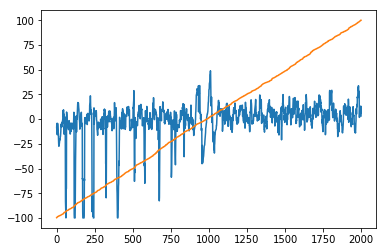

In [38]:
plt.plot(Y_predicted[:].T[0][sort_idx][::])
plt.plot(testing_data_df['tau'].values[sort_idx][::])
plt.show()

In [25]:
Y_predicted[:].T.shape

(1, 2000)

In [26]:
import matplotlib.pyplot as plt

In [27]:
Y_predicted.shape

(2000, 1)

In [28]:
.shape

SyntaxError: invalid syntax (<ipython-input-28-abefa8d9bb1a>, line 1)